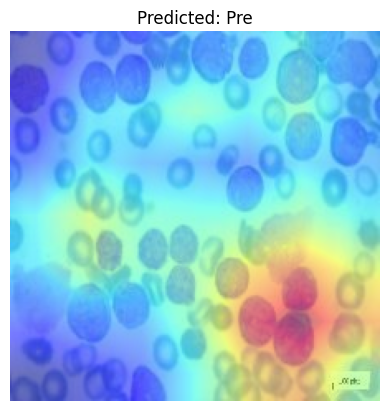

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import os

# -------------------------
# 1. Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

# -------------------------
# 2. Data transforms (same as training)
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_dir = r"C:\Users\94718\OneDrive\Desktop\NIBM\AI\CourseWork\code\try2\Preprocessed"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
classes = dataset.classes

# -------------------------
# 3. Load trained model
# -------------------------
model = models.resnet18(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Custom classifier head
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
)

# Load saved weights
model.load_state_dict(torch.load(r"C:\Users\94718\Downloads\CW\ANN-based-Acute-Lymphoblastic-Leukemia-Classifier\model\resnet18_cancer_model.pth", map_location=device))
model = model.to(device)
model.eval()

# -------------------------
# 4. Grad-CAM
# -------------------------
# Target final conv layer in ResNet18
target_layer = model.layer4[1].conv2
gradcam = LayerGradCam(model, target_layer)

def apply_gradcam(image, label_idx=None):
    image = image.unsqueeze(0).to(device)

    # Forward pass
    output = model(image)
    pred_class = output.argmax(dim=1).item()
    label_idx = label_idx if label_idx is not None else pred_class

    # Grad-CAM attribution
    attributions = gradcam.attribute(image, target=label_idx)
    upsampled_attr = torch.nn.functional.interpolate(
        attributions, size=(224, 224), mode='bilinear'
    )
    heatmap = upsampled_attr.squeeze().cpu().detach().numpy()

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Convert image back for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Overlay Grad-CAM
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Predicted: {classes[pred_class]}")
    plt.axis('off')
    plt.show()

# -------------------------
# 5. Example usage
# -------------------------
sample_img, sample_label = test_dataset[0]
apply_gradcam(sample_img, label_idx=sample_label)
